## Home assignement 2



In [490]:
# import numpy for array manipulation and fft
import numpy as np
# import filtering functionalities from scipy.signal
from scipy.signal import lfilter, filtfilt, butter, freqz
# plotting functionalities
import matplotlib.pyplot as plt
# import numpy fft
from numpy.fft import fft, fftshift, fftfreq

In [491]:
from scipy import signal

If you want to give back the assignement as a jupyter notebook, the following command triggers inline plot.

In [492]:
%matplotlib inline

## Part 1: Multi-frequency signal

We create a function to generate a signal with multiple frequency peaks at multiple locations in time. It will be sum of time-frequency atom functions $x_k$ of the form 
$$
x_{\mu_k,\sigma_k,a_k,f_k}(t)=a_k \cos (2 \pi f_k t)e^{\frac{-(t-\mu_k)^2}{2\sigma_k^2}}
$$

**Question** 1-a: give the analytical expression of the Fourier transform of such atom. (2 points)

$$x_{\mu_k,\sigma_k,a_k,f_k}(t)=f(t)\sqrt{2 \pi \sigma_k^2}g(t)\\
f(t) := a_k \cos (2 \pi f_k t)\rightarrow \hat{f}(\xi)=\frac{a_k}{2}(\delta(\xi+f_k)+\delta(\xi-f_k))\\
g(t) := \mathcal{N}(t|\mu_k, \sigma_k^2)\rightarrow \hat{g}(\xi)=exp(-2\pi^2\sigma_k^2\xi^2-2\pi i \mu_k \xi)\\
\hat{x}(\xi)=\sqrt{2 \pi \sigma_k^2}\hat{f}(\xi)*\hat{g}(\xi)\\
= \frac{a_k}{2} \sqrt{2 \pi \sigma_k^2}(\delta(\xi+f_k)+\delta(\xi-f_k)) * exp(-2\pi^2\sigma_k^2\xi^2-2\pi i \mu_k \xi)\\
= \frac{a_k}{2} \sqrt{2 \pi \sigma_k^2}\delta(\xi+f_k) * exp(-2\pi^2\sigma_k^2\xi^2-2\pi i \mu_k \xi) + \frac{a_k}{2} \sqrt{2 \pi \sigma_k^2}\delta(\xi-f_k) * exp(-2\pi^2\sigma_k^2\xi^2-2\pi i \mu_k \xi)\\
= \frac{a_k}{2} \sqrt{2 \pi \sigma_k^2}(exp(- 2\pi^2\sigma_k^2(\xi+f_k)^2 -2\pi i \mu_k(\xi+f_k))  + exp(- 2\pi^2\sigma_k^2(\xi-f_k)^2 -2\pi i \mu_k(\xi-f_k)) )
$$

*Hint: use the expression of the Fourier transform of a Gaussian from the lecture, as well as multiple calculation rules*

Now we will use the following routine to generate such signal.

In [239]:
def gaussSig(mus,sigmas,amps,freqs,t):
    '''
    Generate a signal based on time frequency atoms:
    Arguments:
    - mus: list/array of time locations
    - sigmas: list/array of temporal widths
    - amps: list/array of amplitudes
    - freqs: list/array of frequency locations
    - t: 1D array of time points
    
    Output:
    - fct: signal evaluated at the given time points
    '''
    fct = 0
    for i in range(len(mus)):
        fct += amps[i]*np.cos(2.*np.pi*freqs[i]*(t))*np.exp(- (t - mus[i])**2/(sigmas[i])**2/2)
    return fct


And use the following signal $x(t)$, sum of three different atoms, sampled at frequency 1kHz = 1000Hz (we use dt=.001 as sampling period).

Text(0.5, 0, 'time (s)')

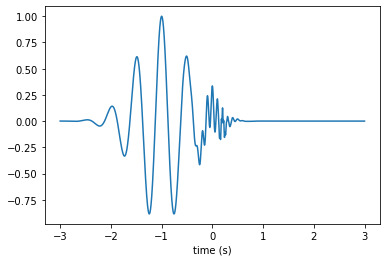

In [240]:
dt=.001;
t = np.arange(-3,3,dt)
mus=[-1,0,.2]
sigmas=[.5,.2,.05]
amps=[1, .2 ,.05]
freqs=[2.,10.,40.]
x = gaussSig(mus,sigmas,amps,freqs,t)
plt.plot(t,x)
plt.xlabel('time (s)')


**Question** 1-b: compute and plot an estimate of the absolute value of the continuous Fourier transform of such signal based on the work done in assignement 1 (using the FFT algorithm). Pay attention to define the frequency axis in physical units (Hz). Use a logrithmic scale For the y-axis. (2)

In [332]:
help(fftshift)

Help on function fftshift in module numpy.fft:

fftshift(x, axes=None)
    Shift the zero-frequency component to the center of the spectrum.
    
    This function swaps half-spaces for all axes listed (defaults to all).
    Note that ``y[0]`` is the Nyquist component only if ``len(x)`` is even.
    
    Parameters
    ----------
    x : array_like
        Input array.
    axes : int or shape tuple, optional
        Axes over which to shift.  Default is None, which shifts all axes.
    
    Returns
    -------
    y : ndarray
        The shifted array.
    
    See Also
    --------
    ifftshift : The inverse of `fftshift`.
    
    Examples
    --------
    >>> freqs = np.fft.fftfreq(10, 0.1)
    >>> freqs
    array([ 0.,  1.,  2., ..., -3., -2., -1.])
    >>> np.fft.fftshift(freqs)
    array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])
    
    Shift the zero-frequency component only along the second axis:
    
    >>> freqs = np.fft.fftfreq(9, d=1./9).reshape(3, 3)
    >>> f

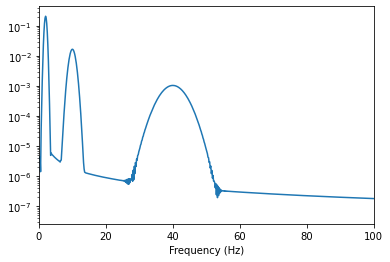

In [241]:
xf = fftshift(fft(x))
f = fftshift(fftfreq(t.size))*(1/dt)
plt.plot(f, 2.0/(t.size) * np.abs(xf))
plt.xlim(0, 100)
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.show()

**Question 1**-c: Explain with maximum detail, how the above plot matches the analytical expression of the Fourier transform established in Q1-a (notably, identify the characteristics of the different atoms composing the signal). (2 points, optional).

## Part 2: Butterworth filters
We will now illustrate band-pass filtering using Infinite Impulse Response filters (IIR). More specifically, we will use the Butterworth filter design routine from the scipy.signal toolbox. This type of filter design is based on a familly of analog (continuous time) filter that can be converted to the digital filters using a specific transformation. One interest of these filters that they require much less coefficients to implement a sharp frequency response due to their recursivity.

In [242]:
help(butter)

Help on function butter in module scipy.signal._filter_design:

butter(N, Wn, btype='low', analog=False, output='ba', fs=None)
    Butterworth digital and analog filter design.
    
    Design an Nth-order digital or analog Butterworth filter and return
    the filter coefficients.
    
    Parameters
    ----------
    N : int
        The order of the filter.
    Wn : array_like
        The critical frequency or frequencies. For lowpass and highpass
        filters, Wn is a scalar; for bandpass and bandstop filters,
        Wn is a length-2 sequence.
    
        For a Butterworth filter, this is the point at which the gain
        drops to 1/sqrt(2) that of the passband (the "-3 dB point").
    
        For digital filters, if `fs` is not specified, `Wn` units are
        normalized from 0 to 1, where 1 is the Nyquist frequency (`Wn` is
        thus in half cycles / sample and defined as 2*critical frequencies
        / `fs`). If `fs` is specified, `Wn` is in the same units as `fs`.


**Question** 2-a. Define a 3-order bandpass Butterworth filter for the band 8-12Hz to select the 10Hz frequency. Plot the two sets of coefficients of the filter. Note the special convention: the frequency parameters 
are normalized using **half** the sampling frequency!!. (2 points)

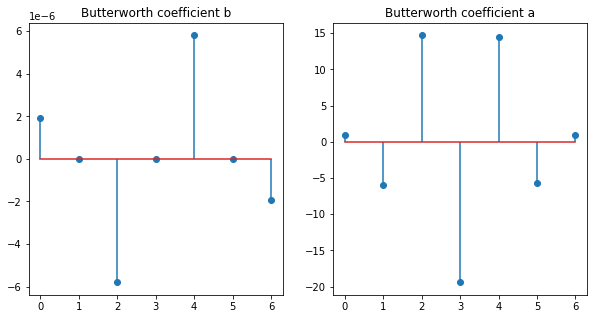

In [243]:
Wn = np.array([8, 12])
N = 3
fs = 1/dt
b, a = butter(N, Wn, 'bandpass', False, 'ba', fs=fs) 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].stem(b,use_line_collection=True)
ax[0].set_title("Butterworth coefficient b")
ax[1].stem(a,use_line_collection=True)
ax[1].set_title("Butterworth coefficient a")
plt.show()

**Question** 2-b: Using the signal $x$ of Q1 as input to the filter, compute the output of the filter using the lfilter routine. Plot the input and output on a same graph (using a linear scale). Interpret the result, does the filtering give the expected result? (2 points)

In [244]:
help(lfilter)

Help on function lfilter in module scipy.signal._signaltools:

lfilter(b, a, x, axis=-1, zi=None)
    Filter data along one-dimension with an IIR or FIR filter.
    
    Filter a data sequence, `x`, using a digital filter.  This works for many
    fundamental data types (including Object type).  The filter is a direct
    form II transposed implementation of the standard difference equation
    (see Notes).
    
    The function `sosfilt` (and filter design using ``output='sos'``) should be
    preferred over `lfilter` for most filtering tasks, as second-order sections
    have fewer numerical problems.
    
    Parameters
    ----------
    b : array_like
        The numerator coefficient vector in a 1-D sequence.
    a : array_like
        The denominator coefficient vector in a 1-D sequence.  If ``a[0]``
        is not 1, then both `a` and `b` are normalized by ``a[0]``.
    x : array_like
        An N-dimensional input array.
    axis : int, optional
        The axis of the input d

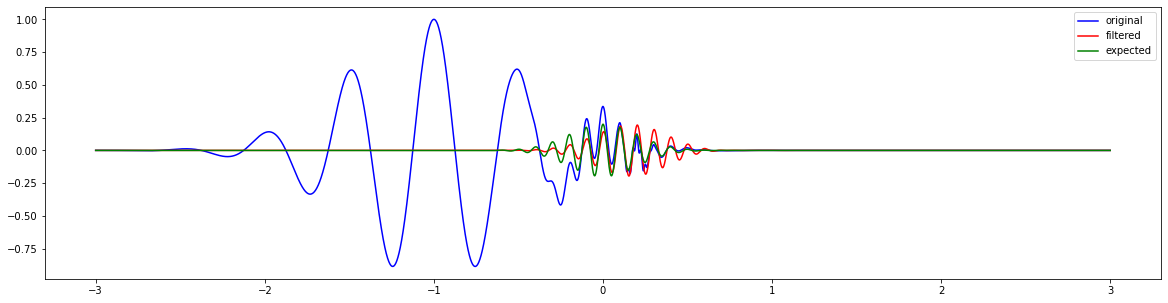

In [245]:
x_filtered = lfilter(b, a, x)

plt.figure(figsize=(20,5))
plt.plot(t,x,color='blue',label='original')
plt.plot(t,x_filtered,color='red',label='filtered')
plt.plot(t,x_expected, color='green',label='expected')

plt.legend()
plt.show()


<div class="alert alert-block alert-success">

**There's a time delay in filtered signal comparing to expected 10Hz signal.**
   
This is because filtered is a *causal forward-in-time* filter. It can't be zero-phase, so there's always time lag in lfilter. Usually it adds different amounts of delay at different frequencies.
</div>

The order parameter affects how rapidly the frequencies outside the passband are attenuated 
(as a function of the distance to the passband). For example, selecting a smaller order results in more prominent peaks for the lowest and largest input frequencies.

**Question** 2-c. Repeat the design of IIR filter in Question 2-a with an order of 2. Plot the Fourier transform of the unfiltered signal and the filtered signals with the order of 2 and 3 using a logarithmic scale for the y-axis, and a linear scale for the frequency axis. Interpret the effect of the order of the filter in this plot. (2 points)

In [246]:
def FFT_XYR(x, dt=dt, t=t):
    xf = fftshift(fft(x))
    f = fftshift(fftfreq(t.size))*(1/dt)
    return xf,f

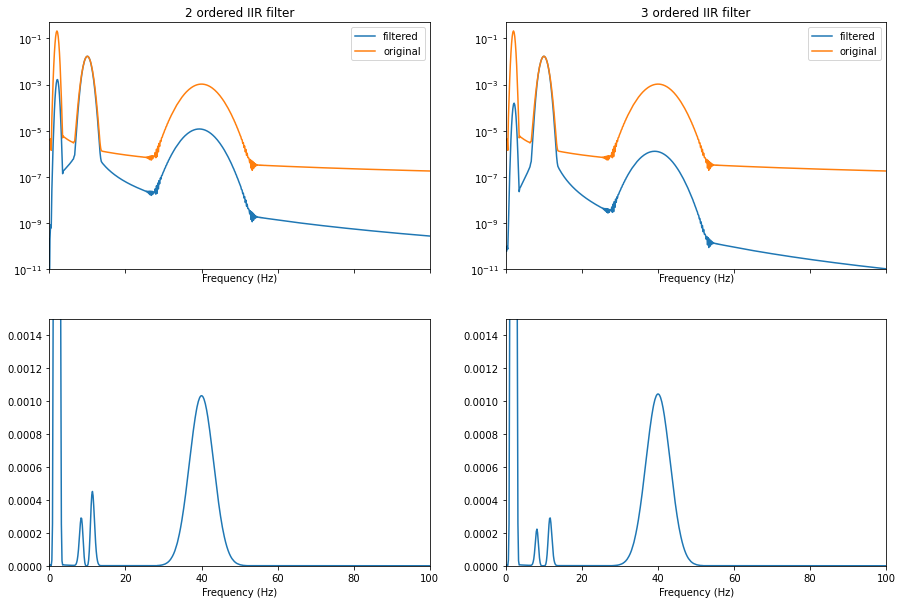

In [247]:
Wn = np.array([8, 12])
N_li = [2,3]
fs = 1/dt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10),sharex=True)
for i,N in enumerate(N_li):
    b, a = butter(N, Wn, 'bandpass', False, 'ba', fs=fs) 
    x_filtered = lfilter(b, a, x)
    xf_original, f_original = FFT_XYR(x)
    xf_filtered, f_filtered = FFT_XYR(x_filtered)
    ax[0,i].plot(f_filtered, 2.0/(t.size) * np.abs(xf_filtered),label='filtered')
    ax[0,i].plot(f_original, 2.0/(t.size) * np.abs(xf_original),label='original')
    ax[0,i].set_xlim(0, 100)
    ax[0,i].set_ylim(1e-11, .5)
    ax[0,i].set_yscale('log')
    ax[0,i].set_xlabel("Frequency (Hz)")
    ax[0,i].set_title('%d ordered IIR filter'%N)
    ax[0,i].legend()
    ax[1,i].plot(f_filtered, 2.0/(t.size) * np.abs(xf_original) - 2.0/(t.size) * np.abs(xf_filtered))
    ax[1,i].set_ylim(0,1.5*1e-3)
    ax[1,i].set_xlim(0, 100)
    ax[1,i].set_xlabel("Frequency (Hz)")

plt.show()


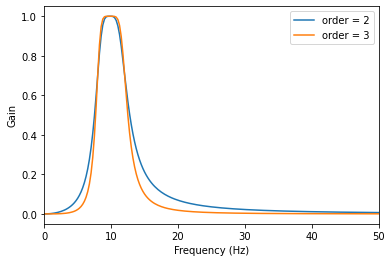

In [493]:
plt.figure()
for i,N in enumerate(N_li):
    b, a = butter(N, Wn, 'bandpass', False, 'ba', fs=fs) 
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" %N)
plt.xlim(0,50)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">

**3 ordered filter keeps more signal from targeted 10Hz.**
   
The higher the order, the sharper the kernel. the two unfiltered part in around 10Hz is from the width of kernel. 
</div>
    


**Question** 2-d: for an arbitrary **real-valued** impulse response $h$, consider the (discrete time) LTI system with impulse response $h*h_\sigma$, convolving $h$ with $h_\sigma[k]=h[-k]$. Compute the frequency response of this system and deduce that it applies a zero-phase lag to any input frequency. (2 points)

Such "zero-phase filter" can be implemented using the routine filtfilt.

<div class="alert alert-block alert-success">
$$\mathcal{F}[h[k]] = H(e^{i\omega})\\
\mathcal{F} [h_\sigma[k]] = \mathcal{F}[h[-k]]=H(e^{-i\omega})\\
\therefore \mathcal{F}[h*h_{\sigma}] = H(e^{i\omega})H(e^{-i\omega}) = |H(e^{i\omega})|^2\\
$$
Thus this filter applies a zero-phase lag to any input frequency. 

</div>

In [250]:
help(filtfilt)

Help on function filtfilt in module scipy.signal._signaltools:

filtfilt(b, a, x, axis=-1, padtype='odd', padlen=None, method='pad', irlen=None)
    Apply a digital filter forward and backward to a signal.
    
    This function applies a linear digital filter twice, once forward and
    once backwards.  The combined filter has zero phase and a filter order
    twice that of the original.
    
    The function provides options for handling the edges of the signal.
    
    The function `sosfiltfilt` (and filter design using ``output='sos'``)
    should be preferred over `filtfilt` for most filtering tasks, as
    second-order sections have fewer numerical problems.
    
    Parameters
    ----------
    b : (N,) array_like
        The numerator coefficient vector of the filter.
    a : (N,) array_like
        The denominator coefficient vector of the filter.  If ``a[0]``
        is not 1, then both `a` and `b` are normalized by ``a[0]``.
    x : array_like
        The array of data to 

**Question** 2-e. Apply *filtfilt*  to Butterworth filter designed in Question 2-a to filter the atom signal. Plot the filtered signals, and the modulus (in semilogy scale) of its Fourier transform and compare the difference with the outcome of *lfilter*. Interpret in line with the above theory question.  (2 points)

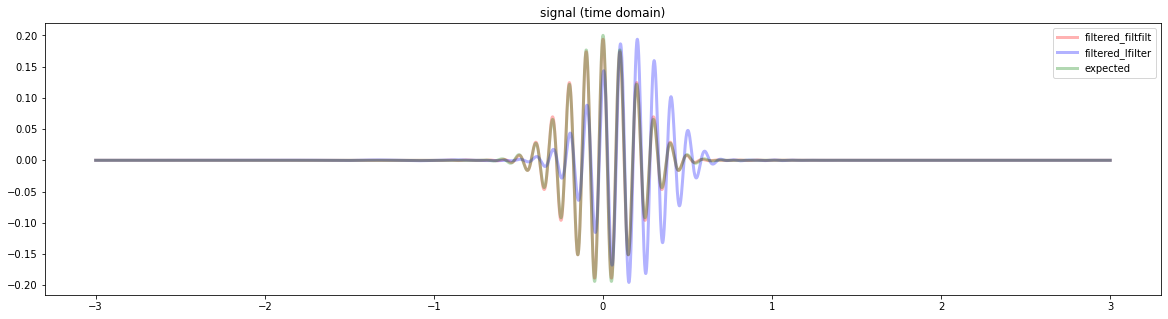

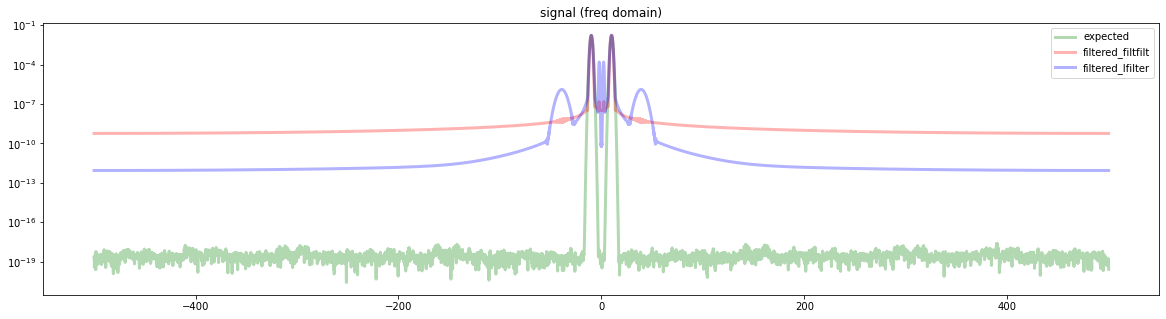

In [257]:
x_filtfilt = filtfilt(b, a, x)
x_lfilter = lfilter(b, a, x)

plt.figure(figsize=(20,5))
plt.title('signal (time domain)')
plt.plot(t,x_filtfilt,color='red',label='filtered_filtfilt',alpha=.3,linewidth=3)
plt.plot(t,x_lfilter,color='blue',label='filtered_lfilter',alpha=.3,linewidth=3)
plt.plot(t,x_expected, color='green',label='expected',alpha=.3,linewidth=3)

plt.legend()
plt.show()

xy_freq, x_freq = FFT_XYR(x_expected)
xy_filtered, x_filtered = FFT_XYR(x_lfilter)
xy_filtfilt, x_filtfilt = FFT_XYR(x_filtfilt)


plt.figure(figsize=(20,5))
plt.title('signal (freq domain)')
plt.plot(x_freq, 2.0/(t.size) * np.abs(xy_freq),color='green',label='expected',alpha=.3,linewidth=3)
plt.plot(x_filtfilt, 2.0/(t.size) * np.abs(xy_filtfilt),color='red',label='filtered_filtfilt',alpha=.3,linewidth=3)
plt.plot(x_filtered, 2.0/(t.size) * np.abs(xy_filtered),color='blue',label='filtered_lfilter',alpha=.3,linewidth=3)

plt.yscale('log')

plt.legend()
plt.show()


<div class="alert alert-block alert-success">

There's a time delay in lfiltered signal comparing to expected 10Hz signal, but filtfilt filtered signal is perfect align with expected 10Hz signal. 
    
</div>

Now we illustrate an important consequence of the uncertainty principle on filter design. 

**Question** 2-f. Assume we want to be more selective and make the selected frequency band narrower. Design a bandpass Butterworth filter as in Question 2-a but with a narrower passband width (1Hz) around 10Hz. Apply the filter to the atom signal and plot the filtered signal in comparison to the original signal. Explain qualitatively why the filtered waveform at 10Hz is less localized in time. (2 points)

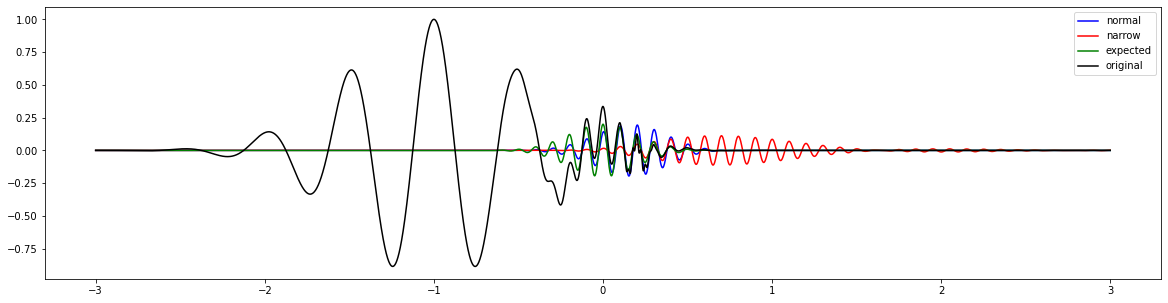

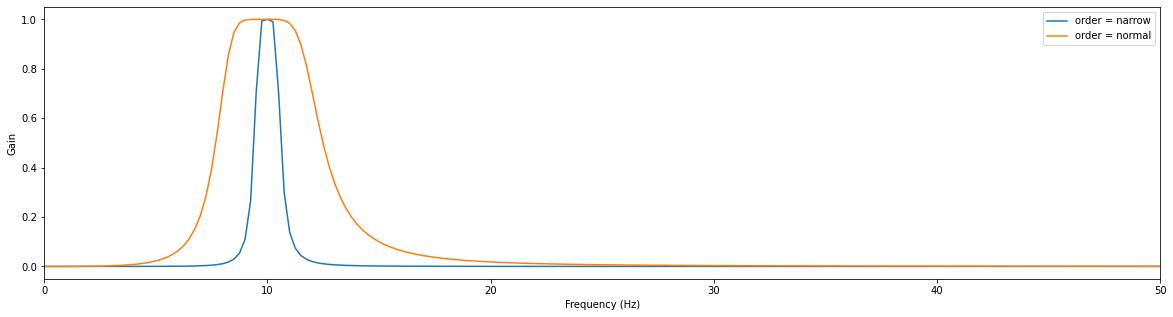

In [261]:
N = 3
fs = 1/dt
b, a = butter(N, np.array([9.5, 10.5]), 'bandpass', False, 'ba', fs=fs) 
x_narrow = lfilter(b, a, x)
b, a = butter(N, np.array([8, 12]), 'bandpass', False, 'ba', fs=fs) 
x_normal = lfilter(b, a, x)
plt.figure(figsize=(20,5))
plt.plot(t,x_normal,color='blue',label='normal')
plt.plot(t,x_narrow,color='red',label='narrow')
plt.plot(t,x_expected, color='green',label='expected')
plt.plot(t,x, color='black',label='original')
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
Wn_name = ['narrow','normal']
Wn_li = [np.array([9.5, 10.5]),np.array([8, 12])]
for i,Wn in enumerate(Wn_li):
    b, a = butter(N, Wn, 'bandpass', False, 'ba', fs=fs) 
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = " +Wn_name[i])
plt.xlim(0,50)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.legend()
plt.show()

## Part 3: A LTI model of neurovascular coupling

Functional Magnetic Resonance Imaging measures the Blood Oxygen Level Dependent (BOLD) signal related to the concentration of oxyhemoglobin in the brain tissue and is used to assess functional brain activity. 

While the link between neural activity and BOLD is complex, involving several non-linear phenomena, and still elusive, the fMRI community has since long used a linear time invariant system to model this relation. The impulse response of this model is called the Hemodynamic Response Function (HRF), and can be used to investiagte properties of neural activity based on fMRI measurements.

### Reference HRF
We first define a reference HRF in continuous time, similar to those used in popular software such as SPM (https://www.fil.ion.ucl.ac.uk/spm/).

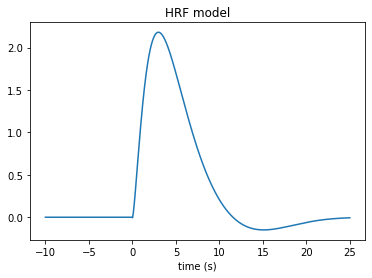

In [292]:
import scipy.stats as stats

def hrf(t):
    pars = [2.5, 2.02, 14.5, 0.247]
    resp = pars[2]*stats.gamma.pdf(t,pars[0],scale = pars[1])-pars[3]*np.exp(-(t-25/2)**2/(12/1.8)**2)
    resp[t<0] = 0
    return resp

t= np.arange(-10,25,.01)

plt.plot(t,hrf(t))
plt.title('HRF model')
plt.xlabel('time (s)')
plt.show()

### LFP based model

As an approximation for the neural activity, i.e. the input of the HRF-based model, we can take the time resolved power of gamma band oscillations (~40-90Hz) of the local-field potential activity recorded intracranially in a monkey brain. You can check this papers for further details:
https://www.ncbi.nlm.nih.gov/pubmed/11449264
https://www.jneurosci.org/content/32/4/1395

Let us load such gamma power signal available at https://owncloud.tuebingen.mpg.de/index.php/s/3HN9jAmGW7miZ4t, sampled at approximately 132Hz (1/dt, and put it in the current directory). We will also remove the mean and normalize the amplitude for simplicity. We will now call this normalized input signal $x$.

Text(0.5, 0, 'time (s)')

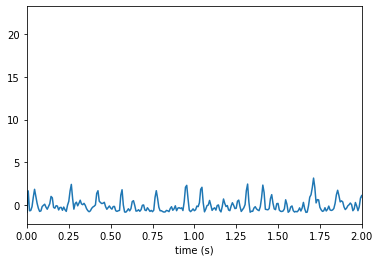

In [293]:
gpow = np.load('gammaPower.npz')
x = gpow['x']
x = x -np.mean(x)
x = x/np.std(x)
dt = gpow['dt']
t = np.arange(len(x))*dt
plt.plot(t,x)
plt.xlim([0,2])
plt.gca().set_xlabel('time (s)')

We use the *hrf* function to sample the impulse response at the sampling frequency of the above downsampled signal $x(t)$ (at approximately 132Hz). Note the impulse response is causal (values before $t=0$ are zero). We can thus sample the hrf on an interval [0,25s]. We will use this sampled HRF, that we will call $h$ to compute an estimate $y$ of the BOLD signal.

(3301,)


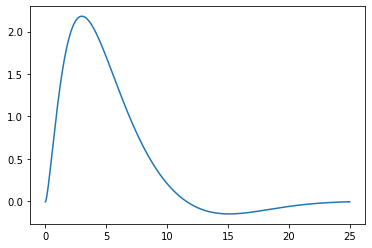

In [294]:
tsamp = np.arange(0,25,dt)
h = hrf(tsamp)
plt.plot(tsamp,h)
print(h.shape)

We use tools from the stats models toolbox to estimate second order statistics.

In [295]:
from statsmodels.tsa.stattools import acovf,ccovf
help(ccovf)

Help on function ccovf in module statsmodels.tsa.stattools:

ccovf(x, y, adjusted=True, demean=True, fft=True)
    Calculate the crosscovariance between two series.
    
    Parameters
    ----------
    x, y : array_like
       The time series data to use in the calculation.
    adjusted : bool, optional
       If True, then denominators for crosscovariance is n-k, otherwise n.
    demean : bool, optional
        Flag indicating whether to demean x and y.
    fft : bool, default True
        If True, use FFT convolution.  This method should be preferred
        for long time series.
    
    Returns
    -------
    ndarray
        The estimated crosscovariance function.



To ease their use, we will use the following function to estimate the cross-correlation between stationnary signals $X[t]$ and $Y[t]$, $\gamma_{XY}(\tau)$ as defined in the lecture:
$$
\gamma_{XY}(\tau) = \mathbb{E}[X[0]Y[\tau]]
$$

In [322]:
def crossCorr(X, Y, maxLag):
    """
    Returns the cross covariance between X and Y up to maximum lag maxLag:
    Arguments:
    - X: first time series,
    - Y: second time series,
    - maxLag: integer maximum lag
    Outputs:
    - corxy: crosscorrelation function
    - tau: lag axis (from -maxLag to +maxLag)
    
    """
    posCor = ccovf(Y,X,adjusted=False)
    negCor = ccovf(X,Y,adjusted=False)
    corxy = np.concatenate([negCor[-1:0:-1],posCor])
    lags = np.arange(-len(negCor)+1,len(posCor))
    idxLag = np.abs(lags)<=maxLag
    tau = lags[idxLag]
    corxy = corxy[idxLag]
    return corxy, tau


**Question 3**
 - (a) (1 point) Generate a simulated BOLD signal $y(t)$ by convolving the gamma power signal $x(t)$ by the sampled HRF $h$ (e.g. using np.convolve), and then adding a Gaussian white noise of variance 1. Plot the resulting simulated BOLD signal.
 

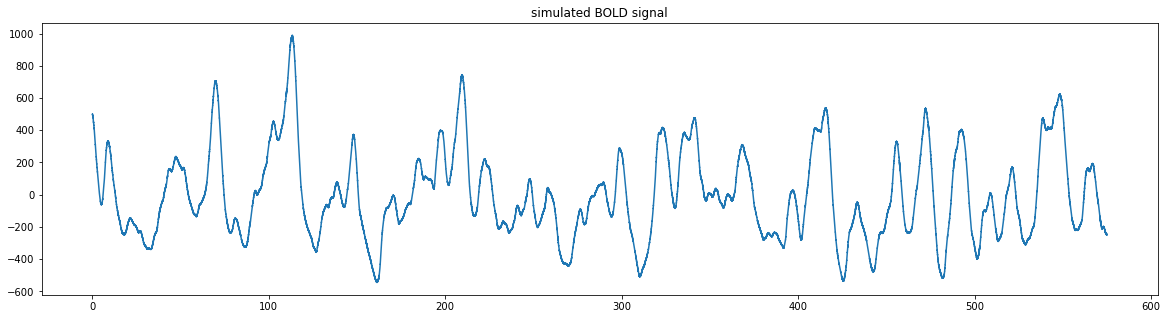

In [426]:
y = np.convolve(x,h,'valid')
y_noise = y+np.random.normal(0,1,size=len(y))
plt.figure(figsize=(20,5))
plt.plot(range(len(y_noise))*dt,y_noise)
plt.title('simulated BOLD signal')
plt.show()

 - (b) (2 points) Compute and plot the autocovariance functions of $x(t)$ and $y(t)$, and the cross-covariance $\gamma_{xy}$  between them for a lag axis of [-40,40] **seconds** (normalize their amplitude to their respective maximum to allow comparison on the same graph). Justify the location of the maxima of the two functions.
 
 

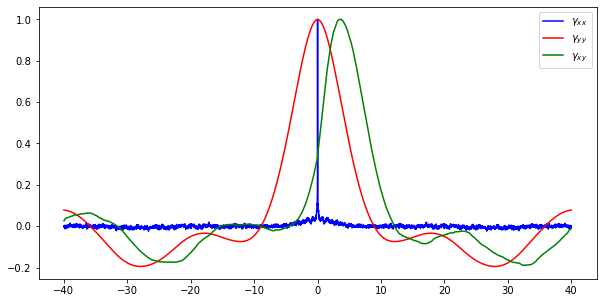

In [445]:

maxLag = int(40/dt)
corxx, tau_x = crossCorr(x, x, maxLag)
coryy, tau_y = crossCorr(y, y_noise, maxLag)
corxy, tau = crossCorr(x, y_noise, maxLag)
corxx_norm = corxx/max(corxx)
coryy_norm = coryy/max(coryy)
corxy_norm = corxy/max(corxy)
plt.figure(figsize=(10,5))
plt.plot(range(-maxLag,maxLag+1)*dt,corxx_norm,color='blue',label='$\gamma_{xx}$')
plt.plot(range(-maxLag,maxLag+1)*dt,coryy_norm,color='red',label='$\gamma_{yy}$')
plt.plot(range(-maxLag,maxLag+1)*dt,corxy_norm,color='green',label='$\gamma_{xy}$')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
    Peak of the autocorrelations $\gamma_{xx}$ and $\gamma_{yy}$ at zero.<br/>
    because $y(t)=hrf(t)*gamma(t)$, y is in response of x(gamma), so the peak of cross-cov is at a positive time lag.
    </div>


 - (c) (3 points) We aim at estimating the filter $h(t)$ based only on its input $x(t)$ and output $y(t)$. Use the cross-correlation function estimates to build the matrix $A$ and vector $d$ seen in lecture 7, slide 15 (identification of a FIR model). To construct $A$, you can check and use the *scipy.linalg.toeplitz* routine. For simplicity, choose the size of the maximum delay $p$ that corresponds to the length of the true sampled HRF $h$.
 

In [451]:
from scipy.linalg import toeplitz
p = h.size
A = toeplitz(corxx[np.where((tau_x>=0)&(tau_x<p))[0]])
d = corxy[np.where((tau>=0)&(tau<p))[0]].reshape((-1, 1))

 - (d) (2 points) Solve the linear system $A\hat{h}=d$, using *scipy.linalg.solve*, in order to get an estimate $\hat{h}$ of $h$. Is the fit qualitatively good?
 

 

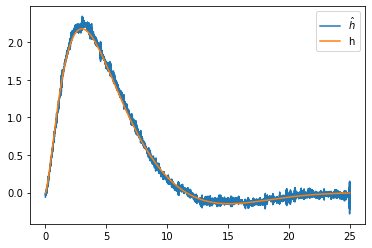

In [452]:
from scipy.linalg import solve
h_estimated = solve(A, d,lower=False)
plt.plot(tsamp, h_estimated.flatten(), label=r'$\hat{h}$')
plt.plot(tsamp, h, label='h')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
    yes, the fit is quite good.
    </div>


 - (e) (2 points) The original estimate was based on the full time course of the signals (600s). Quantify how varies the mean square error of the estimate of $h$ when we estimate auto- and cross-correlation functions only from on initial segment of data of $30$, $100$, and $200s$. 

In [475]:
def calc_mse(t,x,y,dt=dt,maxLag=maxLag,h=h):
    
    corxx, tau_x = crossCorr(x, x, maxLag)
    corxy, tau = crossCorr(x, y, maxLag)
    
    p = h.size
    A = toeplitz(corxx[np.where((tau_x>=0)&(tau_x<p))[0]])
    d = corxy[np.where((tau>=0)&(tau<p))[0]].reshape((-1, 1))
    
    h_estimated = solve(A, d,lower=False)
    
    return mean_squared_error(h, h_estimated)


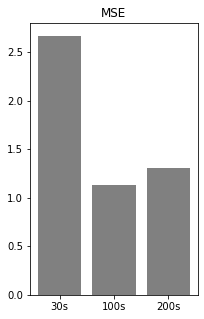

In [489]:
from sklearn.metrics import mean_squared_error
mse_li = []
for t in [30,100,200]:
    mse = calc_mse(t,x[:int(t/dt)],y_noise[:int(t/dt)])
    
    mse_li.append(mse)
plt.figure(figsize=(3,5))
plt.bar(range(3),mse_li,tick_label=['30s','100s','200s'],color = 'grey')
plt.title('MSE')
plt.show()